# Parameter estimation using ES and the 2D Heat Equation

**Note about coordinate system**

Matplotlib's `pcolormesh` follows the standard matrix convention: "An array C with shape (nrows, ncolumns) is plotted with the column number as X and the row number as Y."

This means that to get values at the point `(k, x, y)` of a field `u`, we must do `u[k, y, x]`.

In [1]:
import numpy as np

np.set_printoptions(suppress=True)
rng = np.random.default_rng(12)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams.update({"font.size": 10})
from ipywidgets import interact
import ipywidgets as widgets

from p_tqdm import p_map

from scipy.ndimage import gaussian_filter

import iterative_ensemble_smoother as ies

In [2]:
%load_ext autoreload
%autoreload 2
from dass import pde, utils, analysis, taper

## Define true parameters, set true initial conditions and calculate the true temperature field

Perhaps obvious, but we do not have this information in real-life.

In [3]:
# Number of grid-cells in x and y direction
nx = 10

# time steps
k_start = 0
k_end = 100

dx = 1

# Set the coefficient of heat transfer for each grid cell.
# Using trick from page 15 of "An Introduction to the Numerics of Flow in Porous Media using Matlab".
# It's a nice way to generate realistic-looking parameter fields.
# In real life we use third-party tools to generate good (whatever that means) prior parameter fields.
alpha_t = np.exp(
    5
    * gaussian_filter(gaussian_filter(rng.random(size=(nx, nx)), sigma=2.0), sigma=1.0)
)

# Calculate maximum `dt`.
# If higher values are used, the numerical solution will become unstable.
dt = dx**2 / (4 * np.max(alpha_t))

# True initial temperature field.
u_top = 0.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0
u = np.empty((k_end, nx, nx))
u.fill(0.0)

u[:, :, :] = np.exp(
    8
    * gaussian_filter(gaussian_filter(rng.random(size=(nx, nx)), sigma=2.0), sigma=1.0)
)

# Set the boundary conditions
u[:, (nx - 1) :, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (nx - 1) :] = u_right

# How much noise to add to heat equation.
# scale = 0.1
scale = None

u = pde.heat_equation(u, alpha_t, dx, dt, k_start, k_end, rng=rng, scale=scale)

# How-to create animation (Press `y` to convert from markdown to code)

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
p = ax.pcolormesh(u[0], cmap=plt.cm.jet, vmin=-150, vmax=150)
fig.colorbar(p)

def animate(k):
    return p.set_array(u[k])

anim = animation.FuncAnimation(
    fig, animate, interval=1, frames=k_end, repeat=False
)
anim.save("heat_equation_solution.gif", writer="imagemagick")

## Plot every cells' heat transfer coefficient, i.e., the parameter field

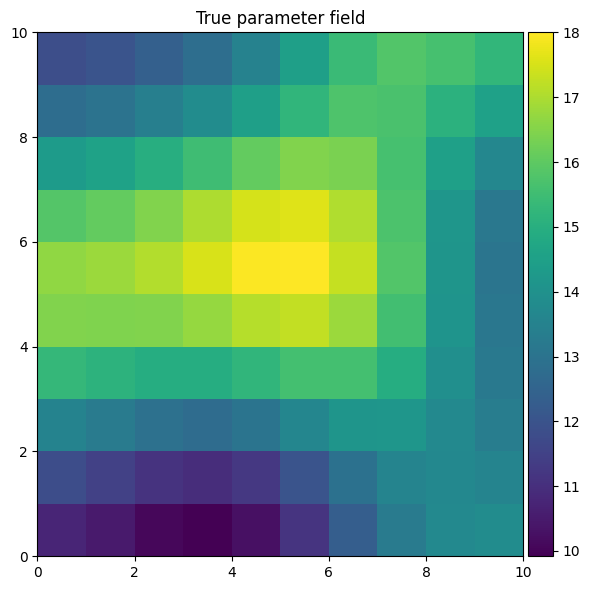

In [4]:
fig, ax = plt.subplots()
ax.set_title("True parameter field")
p = ax.pcolormesh(alpha_t)
utils.colorbar(p)
fig.tight_layout()

## Interactive plot of true temperature field

Shows how the temperature of the true field changes with time.

In [5]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True temperature field")
    p = ax.pcolormesh(u[k], vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.interactive_truth(k)>

## Define placement of sensors and generate synthetic observations based on the true temperature field

Number of observations:  1280


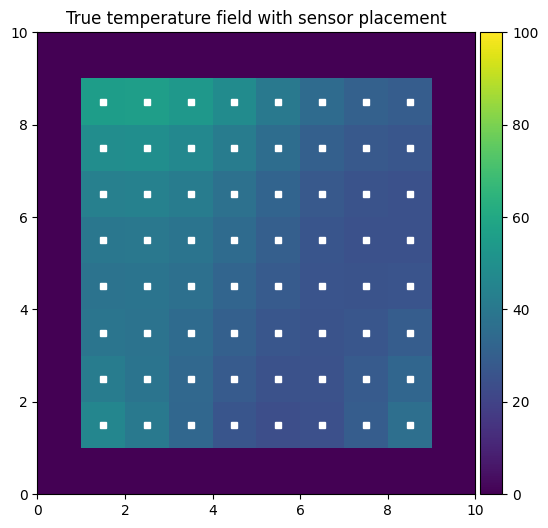

In [6]:
# placement of sensors, i.e, where the observations are done
pad = 1
coords = np.array([(x, y) for x in range(pad, nx - pad) for y in range(pad, nx - pad)])
ncoords = coords.shape[0]
nmeas = 64
coords_idx = np.random.choice(np.arange(ncoords), size=nmeas, replace=False)
obs_coordinates = [utils.Coordinate(xc, yc) for xc, yc in coords[coords_idx]]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 20, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u, lambda value: abs(0.01 * value))
# number of measurements
m = d.shape[0]
print("Number of observations: ", m)

# Plot temperature field and show placement of sensors.
obs_coordinates = set(zip(d.index.get_level_values("x"), d.index.get_level_values("y")))
x, y = zip(*obs_coordinates)

fig, ax = plt.subplots()
p = ax.pcolormesh(u[0], cmap=plt.cm.viridis, vmin=0, vmax=100)
ax.set_title("True temperature field with sensor placement")
utils.colorbar(p)
ax.plot([i + 0.5 for i in x], [j + 0.5 for j in y], "s", color="white", markersize=5)

# Ensemble Smoother (ES) and Iterative Ensemble Smoother (IES)

In [7]:
# Number of realisations
N = 500

## Define random seeds because multiprocessing

https://numpy.org/doc/stable/reference/random/parallel.html#seedsequence-spawning

In [8]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

## Define parameters to run different realisations with, aka the prior

In [9]:
# List of matrices of size (nx, nx) containing priors.
# The reason for having a list is that `p_map` requires it.
# `p_map` runs stuff in parallel.
alphas = []
for i in range(N):
    alpha = np.exp(
        5
        * gaussian_filter(
            gaussian_filter(rng.random(size=(nx, nx)), sigma=2.0), sigma=1.0
        )
    )
    alphas.append(alpha)

# Evensens' formulation of the Ensemble Smoother has the prior as
# a (nx * nx, N) matrix, i.e (number of parameters, N).
A = np.zeros(shape=(nx * nx, N))
for e in range(N):
    A[:, e] = alphas[e].ravel()

## Interactive plot of prior parameter fields

We will search for solutions in the space spanned by the prior parameter fields.
This space is sometimes called the Ensemble Subspace.

In [10]:
def interactive_prior_fields(n):
    fig, ax = plt.subplots()
    ax.set_title(f"Prior field {n}")
    p = ax.pcolormesh(alphas[n])
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_prior_fields,
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='n', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_prior_fields(n)>

## Run forward model (heat equation) `N` times

In [11]:
dt = dx**2 / (4 * np.max(A))
fwd_runs = p_map(
    pde.heat_equation,
    [u] * N,
    alphas,
    [dx] * N,
    [dt] * N,
    [k_start] * N,
    [k_end] * N,
    streams,
    [scale] * N,
    desc=f"Running forward model.",
)

Running forward model.:   0%|          | 0/500 [00:00<?, ?it/s]

## Interactive plot of single realisations

In [12]:
def interactive_realisations(k, n):
    fig, ax = plt.subplots()
    fig.suptitle(f"Temperature field for realisation {n}")
    p = ax.pcolormesh(fwd_runs[n][k], vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_realisations,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=99), IntSlider(value=0, description='n', max=499…

<function __main__.interactive_realisations(k, n)>

## Ensemble representation for measurements (Section 9.4 of [1])

Note that Evensen calls measurements what ERT calls observations.

In [13]:
# Assume diagonal ensemble covariance matrix for the measurement perturbations.
Cdd = np.diag(d.sd.values**2)

# 9.4 Ensemble representation for measurements
E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
E = E - E.mean(axis=1, keepdims=True)
assert E.shape == (m, N)

# We will not use the sample covariance Cee, and instead use Cdd directly.
# It is not clear to us why Cee is proposed used.
# Cee = (E @ E.T) / (N - 1)

D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

## Measure model response at points in time and space where we have observations

In [14]:
Y = np.array(
    [
        fwd_run[
            d.index.get_level_values("k").to_list(),
            d.index.get_level_values("y").to_list(),
            d.index.get_level_values("x").to_list(),
        ]
        for fwd_run in fwd_runs
    ]
).T

assert Y.shape == (
    m,
    N,
), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

In [15]:
enough_ens_var_idx = Y.var(axis=1) > 1e-6
print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
Y = Y[enough_ens_var_idx, :]
D = D[enough_ens_var_idx, :]
Cdd = Cdd[enough_ens_var_idx, :]
Cdd = Cdd[:, enough_ens_var_idx]

0 measurements will be deactivated.


## Perform ES update

In [16]:
X = analysis.ES(Y, D, Cdd)
A_ES = (A - A.mean(axis=1, keepdims=True)) @ X

In [17]:
# The update may give non-physical parameter values, which here means negative heat conductivity.
# Setting negative values to a small positive value but not zero because we want to be able to divide by them.
A_ES = A_ES.clip(min=1e-8)

## Testing the new iterative_ensemble_smoother package

In [18]:
A_ES_ert = ies.ensemble_smoother_update_step(
    Y, A - A.mean(axis=1, keepdims=True), d.sd.values, d.value.values
)

## Comparing prior and posterior

The posterior calculated by ES is on average expected to be closer to the truth than the prior.
By "closer", we mean in terms of Root Mean Squared Error (RMSE).
The reason for this is that ES is based on the Kalman Filter, which is the "Best Linear Unbiased Estimator" (BLUE) and BLUE estimators have this property.
However, this holds for certain only when the number of realizations tends to infinity.
In practice this mean that we might end up with an increased RMSE when using a finite number of realizations.

In [19]:
err_posterior = alpha_t.ravel() - A_ES.mean(axis=1)
np.sqrt(np.mean(err_posterior * err_posterior))

2.2147151426891143

In [20]:
err_posterior_ert = alpha_t.ravel() - A_ES_ert.mean(axis=1)
np.sqrt(np.mean(err_posterior_ert * err_posterior_ert))

3.2144762486107004

In [21]:
err_prior = alpha_t.ravel() - A.mean(axis=1)
np.sqrt(np.mean(err_prior * err_prior))

2.6537953329964385

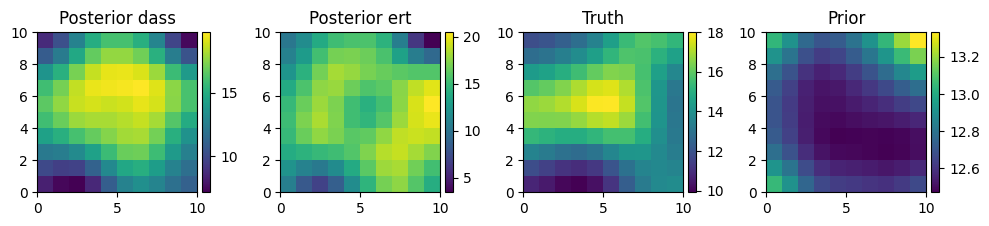

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(10, 10)

ax[0].set_title(f"Posterior dass")
ax[1].set_title(f"Posterior ert")
ax[2].set_title(f"Truth")
ax[3].set_title(f"Prior")

p0 = ax[0].pcolormesh(A_ES.mean(axis=1).reshape(nx, nx))
p1 = ax[1].pcolormesh(A_ES_ert.mean(axis=1).reshape(nx, nx))
p2 = ax[2].pcolormesh(alpha_t)
p3 = ax[3].pcolormesh(A.mean(axis=1).reshape(nx, nx))

utils.colorbar(p0)
utils.colorbar(p1)
utils.colorbar(p2)
utils.colorbar(p3)

ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")
ax[2].set_aspect("equal", "box")
ax[3].set_aspect("equal", "box")

fig.tight_layout()

# IES

In [23]:
# Step length in Gauss Newton
gamma = 1.0

# Coefficient matrix as defined in Eq. 16 and Eq. 17.
W = np.zeros(shape=(N, N))

## Check that single iteration of IES with step length 1.0 is the same as ES.

In [24]:
W = analysis.IES(Y, D, Cdd, W, gamma)
X_IES = np.identity(N) + W